In [ ]:
!unzip traffic_Data.zip

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import csv

with open('labels.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None)
    int2label = dict((rows[0],rows[1]) for rows in reader)

In [5]:
import shutil
import os

def remove_slash_from_dict(input_dict):
    cleaned_dict = {key: value.replace('/', '') for key, value in input_dict.items()}
    return cleaned_dict

def get_folder_names(directory):
    try:
        folder_names = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
        return folder_names
    except OSError as e:
        print(f"Error: {e}")
        return None

def delete_folder(folder_path):
    try:
        # Use shutil.rmtree to delete the folder and its contents
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' deleted successfully.")
    except FileNotFoundError:
        print(f"Error: Folder '{folder_path}' not found.")
    except Exception as e:
        print(f"Error: Unable to delete folder '{folder_path}'. {e}")

def merge_folders(folder1, folder2):
    # Check if the merge folder (folder1) already exists
    if not os.path.exists(folder1):
        os.makedirs(folder1)

    # Copy the contents of the second folder (folder2) into the first folder (folder1)
    for item in os.listdir(folder2):
        source_path = os.path.join(folder2, item)
        destination_path = os.path.join(folder1, item)

        if os.path.isdir(source_path):
            shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
        else:
            shutil.copy2(source_path, destination_path)

    print(f"Folders {folder2} merged into {folder1}")
    delete_folder(folder_path=folder2)

def rename_or_merge_folder_in_directory(old_name, new_name, directory):
  old_name_path = os.path.join(directory, old_name)
  new_name_path = os.path.join(directory, new_name)
  if new_name in os.listdir(directory):
    merge_folders(new_name_path, old_name_path)
  else:
    try:
        os.rename(old_name_path, new_name_path)
        print(f"Folder '{old_name}' renamed to '{new_name}' successfully.")
    except OSError as e:
        print(f"Error: {e}")

In [ ]:
int2label = remove_slash_from_dict(int2label)
DIRECTORY = 'DATA'
old_names = get_folder_names(directory=DIRECTORY)
for old_name in old_names :
  new_name = int2label.get(old_name)
  rename_or_merge_folder_in_directory(old_name, new_name, directory=DIRECTORY)

In [7]:
def get_train_val_generators(DIRECTORY, classes):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator: tuple containing the generators
  """

  datagen = ImageDataGenerator(
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      fill_mode='nearest',
                                      validation_split=0.2
                                     )

  train_generator = datagen.flow_from_directory(directory=DIRECTORY,
                                                batch_size=32,
                                                class_mode='sparse',
                                                target_size=(160, 160),
                                                subset='training',
                                                classes=classes
                                                )

  val_generator = datagen.flow_from_directory(directory=DIRECTORY,
                                              batch_size=32,
                                              class_mode='sparse',
                                              target_size=(160, 160),
                                              subset='validation',
                                              classes=classes
                                              )



  return train_generator, val_generator

In [8]:
classes = os.listdir(DIRECTORY)
num_classes = len(classes)
train_generator, val_generator = get_train_val_generators(DIRECTORY=DIRECTORY, classes=classes)

Found 3358 images belonging to 55 classes.
Found 812 images belonging to 55 classes.


In [9]:
def preprocess_input(input):
  return tf.keras.applications.mobilenet_v2.preprocess_input(input)

In [10]:
def get_base_model():
  base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
  base_model.trainable = False
  return base_model

In [49]:
base_model = get_base_model()
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [50]:
def create_model(base_model, num_classes) :
  inputs = tf.keras.Input(shape=(160,160,3))
  x = preprocess_input(inputs)
  x = base_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
  final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return final_model

In [51]:
model = create_model(base_model, num_classes=num_classes)

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [52]:
learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [53]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [54]:
epochs=100
history = model.fit(
                  train_generator,
                  epochs=epochs,
                  validation_data=val_generator,
                  callbacks=[early_stopping_callback]
                  )

Epoch 1/100
105/105 [==============================] - 38s 322ms/step - loss: 1.2703 - accuracy: 0.6691 - val_loss: 0.7321 - val_accuracy: 0.7857
Epoch 2/100
105/105 [==============================] - 34s 329ms/step - loss: 0.4758 - accuracy: 0.8505 - val_loss: 0.5672 - val_accuracy: 0.8140
Epoch 3/100
105/105 [==============================] - 32s 306ms/step - loss: 0.3239 - accuracy: 0.8961 - val_loss: 0.4034 - val_accuracy: 0.8682
Epoch 4/100
105/105 [==============================] - 37s 352ms/step - loss: 0.2480 - accuracy: 0.9172 - val_loss: 0.2333 - val_accuracy: 0.9261
Epoch 5/100
105/105 [==============================] - 32s 307ms/step - loss: 0.2060 - accuracy: 0.9321 - val_loss: 0.2869 - val_accuracy: 0.8990
Epoch 6/100
105/105 [==============================] - 34s 322ms/step - loss: 0.1649 - accuracy: 0.9455 - val_loss: 0.1510 - val_accuracy: 0.9557
Epoch 7/100
105/105 [==============================] - 32s 308ms/step - loss: 0.1699 - accuracy: 0.9387 - val_loss: 0.2119 -

In [55]:
base_model.trainable = True
for layer in model.layers :
  if 'dense' in str(layer) :
    layer.trainable = False

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [56]:
learning_rate_for_fine_tuning = learning_rate / 100
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_for_fine_tuning),
              metrics=['accuracy'])

In [57]:
model_dir = 'best_model'
callbacks = [
    early_stopping_callback,
    tf.keras.callbacks.ModelCheckpoint(model_dir, monitor='val_loss', save_best_only=True)
    ]

In [58]:
fine_tune_epochs = 100
total_epochs =  history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator,
                         callbacks=callbacks)

Epoch 19/118
105/105 [==============================] - 68s 523ms/step - loss: 1.6360 - accuracy: 0.6263 - val_loss: 0.3233 - val_accuracy: 0.9273
Epoch 20/118
105/105 [==============================] - 36s 347ms/step - loss: 0.8618 - accuracy: 0.7719 - val_loss: 0.4427 - val_accuracy: 0.9015
Epoch 21/118
105/105 [==============================] - 38s 367ms/step - loss: 0.5548 - accuracy: 0.8395 - val_loss: 0.5638 - val_accuracy: 0.8867
Epoch 22/118
105/105 [==============================] - 39s 375ms/step - loss: 0.4133 - accuracy: 0.8794 - val_loss: 0.5122 - val_accuracy: 0.8978
Epoch 23/118
105/105 [==============================] - 37s 353ms/step - loss: 0.2978 - accuracy: 0.9089 - val_loss: 0.3277 - val_accuracy: 0.9212
Epoch 24/118
105/105 [==============================] - 53s 510ms/step - loss: 0.2268 - accuracy: 0.9273 - val_loss: 0.2573 - val_accuracy: 0.9310
Epoch 25/118
105/105 [==============================] - 54s 514ms/step - loss: 0.1963 - accuracy: 0.9381 - val_loss: 0

In [59]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

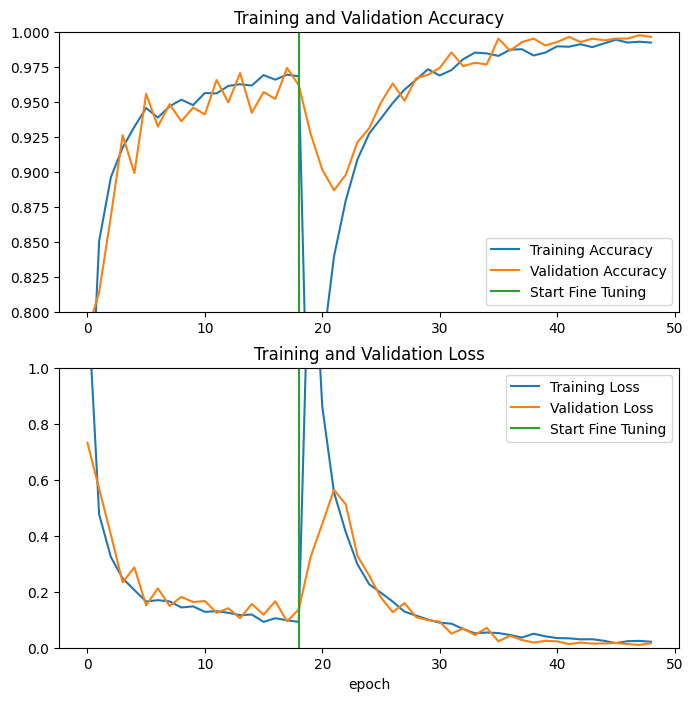

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([history.epoch[-1], history.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([history.epoch[-1], history.epoch[-1]],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
best_model = tf.keras.models.load_model(model_dir)
best_model.evaluate(val_generator)

26/26 [==============================] - 8s 274ms/step - loss: 0.0082 - accuracy: 0.9988


[0.008244643919169903, 0.9987684488296509]

In [65]:
images, labels = next(val_generator)
predictions = model.predict(images)

1/1 [==============================] - 1s 1s/step


In [66]:
import numpy as np

def postprocess_predictions(predictions) :
  y_pred = np.apply_along_axis(np.argmax, axis=1, arr=predictions)
  return y_pred

In [67]:
y_pred = postprocess_predictions(predictions)

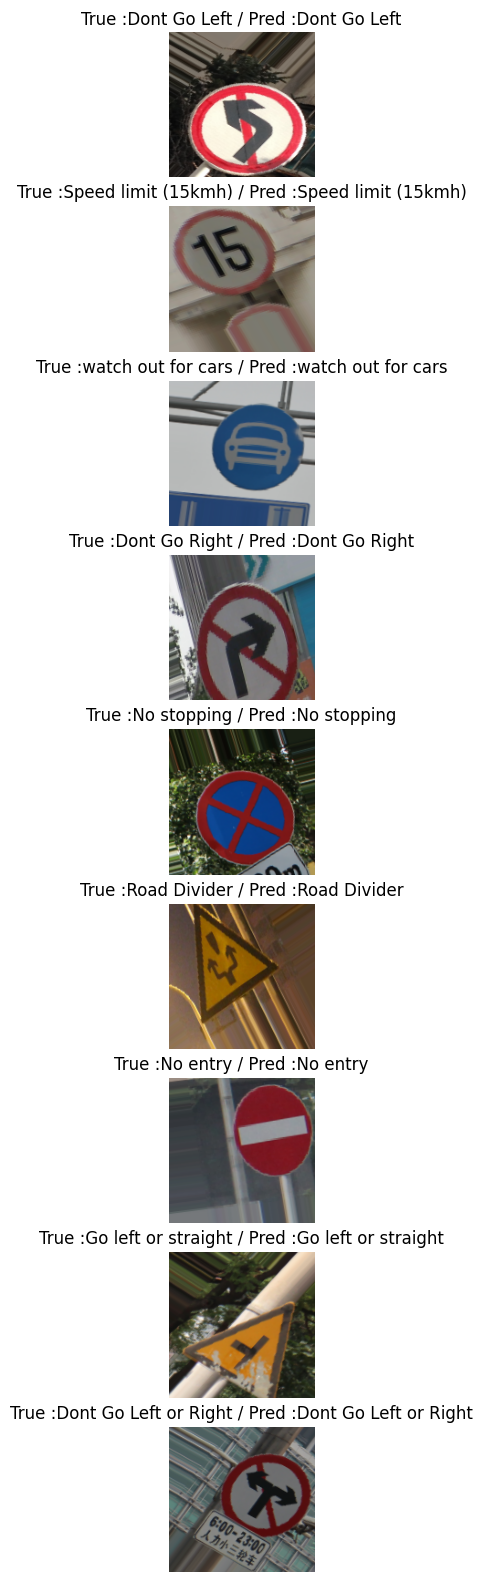

In [68]:
plt.figure(figsize=(20, 20))
for i in range(9):
  ax = plt.subplot(9, 1, i + 1)
  plt.imshow(images[i].astype("uint8"))
  plt.title('True :' + classes[int(labels[i])] + ' / Pred :' + classes[int(y_pred[i])])
  plt.axis("off")